In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
 # Load csv file of bitcoin data
csv_path = Path("BTC2016.csv")
btc=pd.read_csv(csv_path)
btc.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2016-07-28,655.42700,656.91599,658.63100,654.16099
1,BTC,2016-07-29,656.68100,655.42700,658.25299,654.38500
2,BTC,2016-07-30,635.58800,656.68100,658.28300,634.84899
3,BTC,2016-07-31,621.37299,635.58800,639.38199,616.04800
4,BTC,2016-08-01,601.22700,621.37299,627.06800,600.74100


In [3]:
btc = btc.drop(columns="Currency")

In [4]:
btc['Date']=btc['Date'].astype('datetime64[ns]')

In [5]:
# Set the `Date` column as the index
btc = btc.set_index("Date", drop=True)

In [6]:
btc.head()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,
2016-07-28,655.42700,656.91599,658.63100,654.16099
2016-07-29,656.68100,655.42700,658.25299,654.38500
2016-07-30,635.58800,656.68100,658.28300,634.84899
2016-07-31,621.37299,635.58800,639.38199,616.04800
2016-08-01,601.22700,621.37299,627.06800,600.74100


In [7]:
# Rename the columns
btc.columns = ['Close', 'Open', 'High', 'Low']
btc.head()

,Close,Open,High,Low
Date,,,,
2016-07-28,655.42700,656.91599,658.63100,654.16099
2016-07-29,656.68100,655.42700,658.25299,654.38500
2016-07-30,635.58800,656.68100,658.28300,634.84899
2016-07-31,621.37299,635.58800,639.38199,616.04800
2016-08-01,601.22700,621.37299,627.06800,600.74100


In [8]:
## Initialize the short and long windows
short_window = 4
long_window = 100

In [9]:
## Initialize the signals DataFrame with the signal column

signals = pd.DataFrame(index=btc.index)
signals['close'] = btc['Close']
signals['signal'] = 0.0

In [10]:
## Create short simple moving average over the short window

signals['SMA4'] = btc['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

In [11]:
## Create long simple moving average over the long window

signals['SMA100'] = btc['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

In [12]:
## Create signals

signals['signal'][short_window:] = np.where(signals['SMA4'][short_window:] > signals['SMA100'][short_window:],1.0,0.0)

In [13]:
## Generate trading orders

signals['entry/exit'] = signals['signal'].diff()

In [14]:
signals.head()

,close,signal,SMA4,SMA100,entry/exit
Date,,,,,
2016-07-28,655.42700,0.0,655.427000,655.427000,NaN
2016-07-29,656.68100,0.0,656.054000,656.054000,0.0
2016-07-30,635.58800,0.0,649.232000,649.232000,0.0
2016-07-31,621.37299,0.0,642.267247,642.267247,0.0
2016-08-01,601.22700,0.0,628.717247,634.059198,0.0


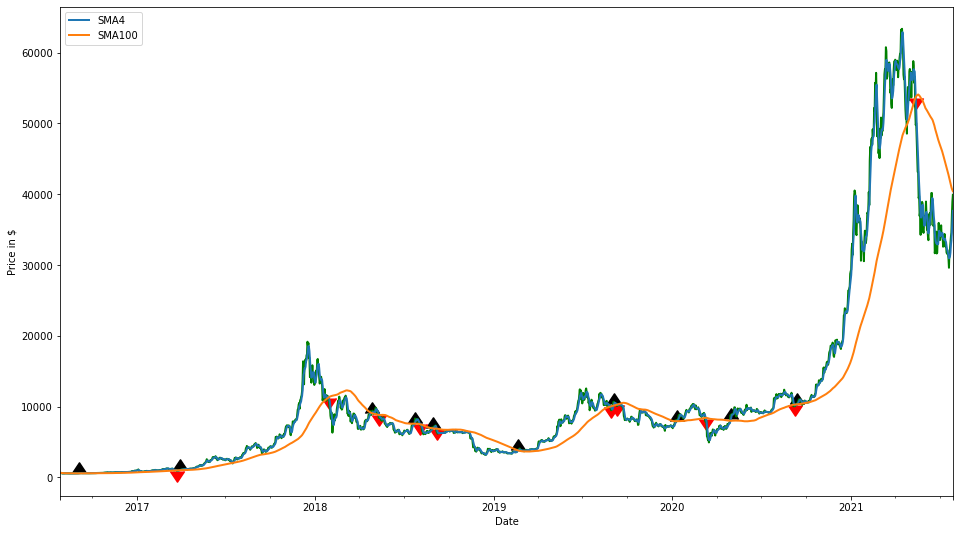

In [15]:
## Initialize the plot figure

fig = plt.figure(figsize=(16,9))

## Add a subplot and label for y-axis

ax1 = fig.add_subplot(111,ylabel='Price in $')

## Plot the closing price

btc['Close'].plot(ax=ax1, color='g', lw=2.)

## Plot the short and long moving averages

signals[['SMA4','SMA100']].plot(ax=ax1, lw=2.)

## Plot the buy signals

#signals.short_mavg[signals.positions == 1.0].scatter(ax=ax1, color='g')
plt.scatter(signals.loc[signals['entry/exit'] == 1.0].index, 
            signals.SMA4[signals['entry/exit'] == 1.0],
            marker=10, s=200, color='black')

## Plot the sell signals
plt.scatter(signals.loc[signals['entry/exit'] == -1.0].index,
            signals.SMA4[signals['entry/exit'] == -1.0],
            marker=11, s=200, color='r')


## Show the plot

plt.show()

### Backtest the Trading Strategy

In [16]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals['Position'] = share_size * signals['signal']

# Find the points in time where a 500 share position is bought or sold
signals['Entry/Exit Position'] = signals['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
signals['Portfolio Holdings'] = signals['close'] * signals['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals['Portfolio Cash'] = initial_capital - (signals['close'] * signals['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals['PortfolioTotal'] = signals['Portfolio Cash'] + signals['Portfolio Holdings']

# Calculate the portfolio daily returns
signals['Portfolio Daily Returns'] = signals['PortfolioTotal'].pct_change()

# Calculate the cumulative returns
signals['Portfolio Cumulative Returns'] = (1 + signals['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
signals.tail()

,close,signal,SMA4,SMA100,entry/exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,PortfolioTotal,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2021-07-24,34014.618359,0.0,32837.542873,41260.712441,0.0,0.0,0.0,0.0,2.694047e+07,2.694047e+07,0.0,268.404718
2021-07-25,34574.670661,0.0,33477.601530,40986.801322,0.0,0.0,0.0,0.0,2.694047e+07,2.694047e+07,0.0,268.404718
2021-07-26,37114.296624,0.0,34705.334276,40752.199841,0.0,0.0,0.0,0.0,2.694047e+07,2.694047e+07,0.0,268.404718
2021-07-27,38963.922857,0.0,36166.877125,40573.330768,0.0,0.0,0.0,0.0,2.694047e+07,2.694047e+07,0.0,268.404718
2021-07-28,39917.449369,0.0,37642.584878,40410.264246,0.0,0.0,0.0,0.0,2.694047e+07,2.694047e+07,0.0,268.404718


### Plot Entry/Exit Points of Trading Strategy vs. Backtest Results

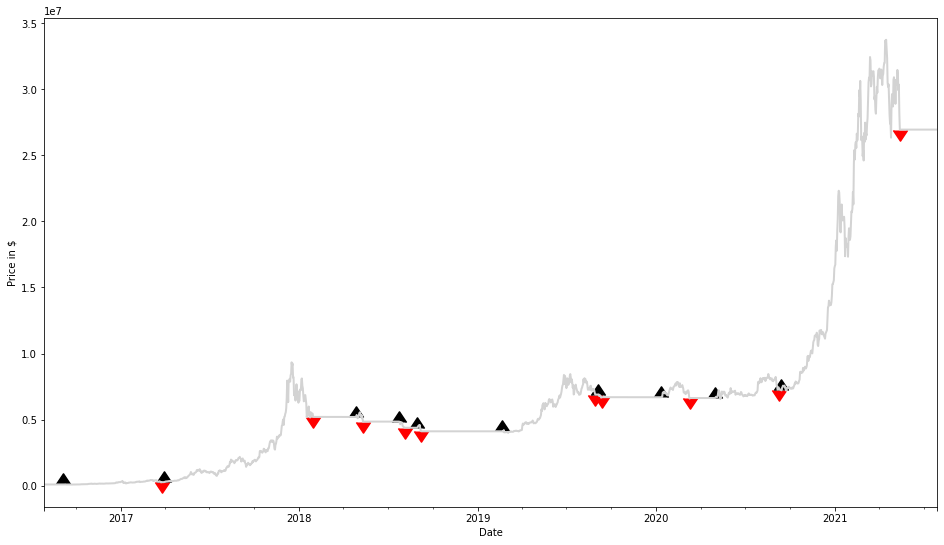

In [17]:
# Visualize exit position relative to total portfolio value
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111,ylabel='Price in $')

## Plot the total portoflio value for the investment
#btc['Close'].plot(ax=ax1, color='g', lw=2.)
signals['PortfolioTotal'].plot(ax=ax1, color='lightgrey', lw=2.)

# Plot exit position relative to total portfolio value
plt.scatter(signals.loc[signals['entry/exit'] == -1.0].index,
            signals.PortfolioTotal[signals['entry/exit'] == -1.0],
            marker=11, s=200, color='r')

# Plot entry position relative to total portfolio value
plt.scatter(signals.loc[signals['entry/exit'] == 1.0].index,
            signals.PortfolioTotal[signals['entry/exit'] == 1.0],
            marker=10, s=200, color='black')

In [18]:
signals[signals['entry/exit'] == 1.0]['PortfolioTotal']

Date
2016-09-04    1.000000e+05
2017-03-30    2.782278e+05
2018-04-26    5.212372e+06
2018-07-24    4.856671e+06
2018-08-30    4.391790e+06
2019-02-20    4.122467e+06
2019-09-04    6.904086e+06
2020-01-10    6.702939e+06
2020-04-30    6.638827e+06
2020-09-12    7.276588e+06
Name: PortfolioTotal, dtype: float64

### portofolio evaluation metrics

In [19]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [20]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = signals['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    signals['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    signals['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    signals['Portfolio Daily Returns'].mean() * 252) / (
    signals['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = signals[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
portfolio_evaluation_df

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

,Backtest
Annual Return,0.934467
Cumulative Returns,268.404718
Annual Volatility,0.56556
Sharpe Ratio,1.652286
Sortino Ratio,2.565904


### Trade Evaluation Metrics

In [21]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Cryptocurrency', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

,Cryptocurrency,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [22]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in signals.iterrows():
    if row['entry/exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['close']

    elif row['entry/exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
        exit_share_price = row['close']
        profit_loss =  exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Cryptocurrency': 'BTC',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

,Cryptocurrency,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,BTC,2016-09-04,2017-03-25,500.0,606.052500,962.508000,3.030262e+05,4.812540e+05,1.782278e+05
1,BTC,2017-03-30,2018-01-29,500.0,1048.862990,10917.151250,5.244315e+05,5.458576e+06,4.934144e+06
2,BTC,2018-04-26,2018-05-12,500.0,9153.641250,8442.238750,4.576821e+06,4.221119e+06,-3.557012e+05
3,BTC,2018-07-24,2018-08-04,500.0,8325.801534,7396.041122,4.162901e+06,3.698021e+06,-4.648802e+05
4,BTC,2018-08-30,2018-09-07,500.0,6938.914582,6400.268706,3.469457e+06,3.200134e+06,-2.693229e+05
5,BTC,2019-02-20,2019-08-29,500.0,3924.739844,9487.976434,1.962370e+06,4.743988e+06,2.781618e+06
6,BTC,2019-09-04,2019-09-11,500.0,10555.046901,10152.752984,5.277523e+06,5.076376e+06,-2.011470e+05
7,BTC,2020-01-10,2020-03-10,500.0,8087.452885,7959.228274,4.043726e+06,3.979614e+06,-6.411231e+04
8,BTC,2020-04-30,2020-09-08,500.0,8767.672623,10043.196441,4.383836e+06,5.021598e+06,6.377619e+05
9,BTC,2020-09-12,2021-05-13,500.0,10436.365408,49764.132082,5.218183e+06,2.488207e+07,1.966388e+07
